# data preproccessing


## import modules and configure notebook

In [1]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from functions.preproccessing import clean_columns, split_data, replace_outliers 

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)
%matplotlib inline

C:\Users\tom\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
from config_and_dependencies.config import * 

### Import data

In [3]:
my_data = pd.read_csv(data_input_path)

<AxesSubplot:xlabel='Site', ylabel='count'>

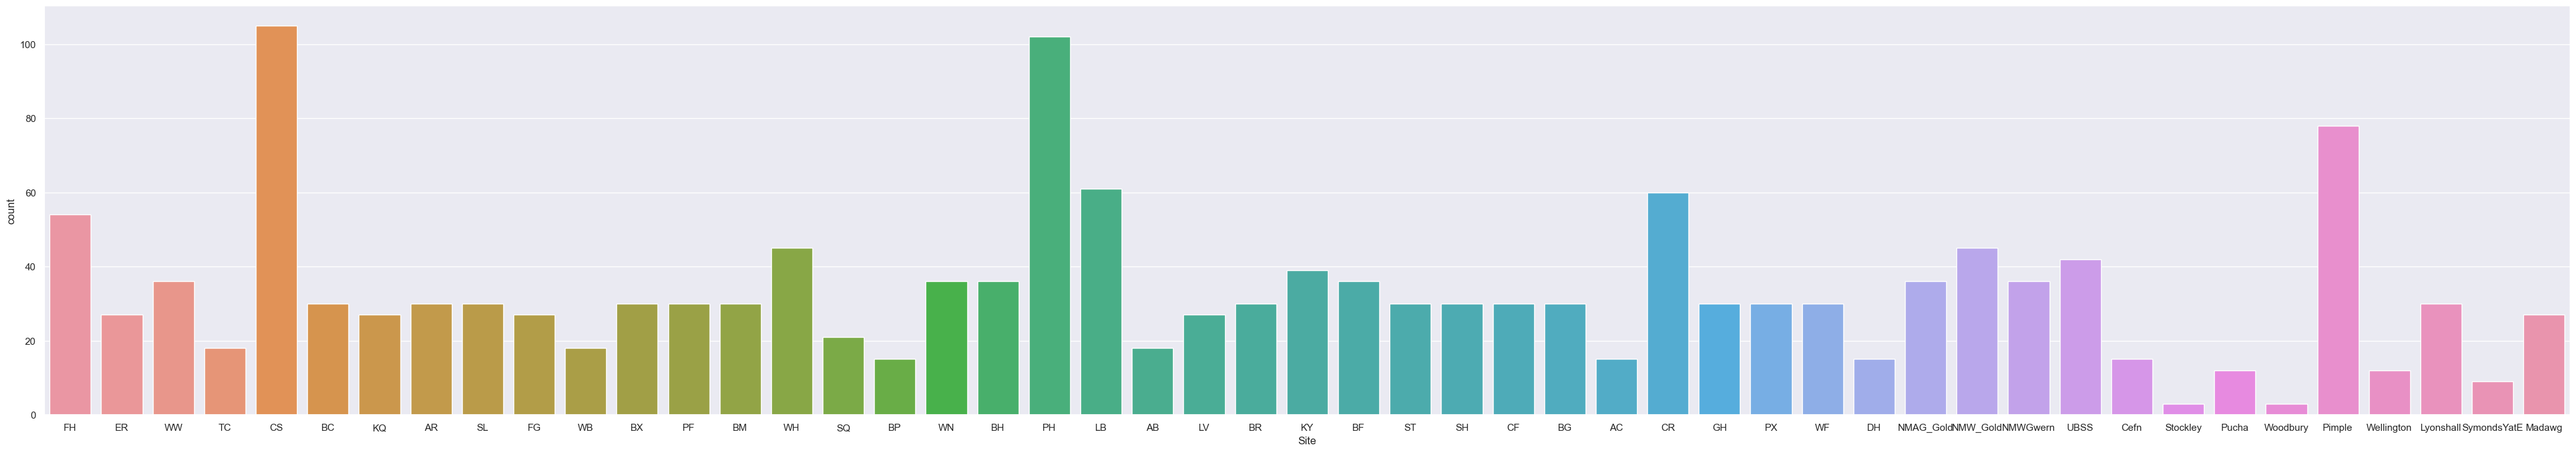

In [4]:
sns.set(rc={'figure.figsize':(50.7,8.27)})
sns.countplot(x=my_data['Site'])

In [5]:
my_data['class'] = my_data['Site']

### features

In [6]:
my_data.columns.values[features_start:features_end]

array(['Li7', 'Be9', 'B11', 'Mg24', 'Al27', 'Si28', 'P31', 'S33', 'K39',
       'Ca42', 'Sc45', 'Ti47', 'V51', 'Cr52', 'Mn55', 'Fe56', 'Co59',
       'Ni60', 'Cu63', 'Zn68', 'Ga69', 'Ge72', 'As75', 'Rb85', 'Sr88',
       'Y89', 'Zr90', 'Nb93', 'Mo95', 'Cd111', 'In115', 'Sn118', 'Cs133',
       'Ba137', 'La139', 'Ce140', 'Pr141', 'Nd146', 'Sm147', 'Eu153',
       'Gd157', 'Tb159', 'Dy163', 'Ho165', 'Er166', 'Tm169', 'Yb172',
       'Lu175', 'Hf178', 'Ta181', 'Pb208', 'Th232', 'U238'], dtype=object)

In [7]:
site_frequencies_df = pd.DataFrame(my_data.Site.value_counts()).reset_index(drop = False).rename(columns = {'Site':'Number of Observations', 'index':'Site'})
%store site_frequencies_df

Stored 'site_frequencies_df' (DataFrame)


### raw sample names including sample sites and artefacts

In [8]:
my_data['Site'].unique()

array(['FH', 'ER', 'WW', 'TC', 'CS', 'BC', 'KQ', 'AR', 'SL', 'FG', 'WB',
       'BX', 'PF', 'BM', 'WH', 'SQ', 'BP', 'WN', 'BH', 'PH', 'LB', 'AB',
       'LV', 'BR', 'KY', 'BF', 'ST', 'SH', 'CF', 'BG', 'AC', 'CR', 'GH',
       'PX', 'WF', 'DH', 'NMAG_Gold', 'NMW_Gold', 'NMWGwern', 'UBSS',
       'Cefn', 'Stockley', 'Pucha', 'Woodbury', 'Pimple', 'Wellington',
       'Lyonshall', 'SymondsYatE', 'Madawg'], dtype=object)

In [9]:
my_data['Region'].unique()

array([nan, 'AB', 'LV', 'SV_SE_black', 'BA_black', 'BA_grey',
       'SV_SE_grey', 'WA_grey', 'WA_black', 'MM_black', 'MM_grey'],
      dtype=object)

### define functions for making target classes for classification

In [10]:
def make_classes_grouped_reduced(row):
    if row['Geology'] == 'Bedrock':
        return(row['Site'])
#    elif row['Geology'] == 'Superficial':
#        return(row['Region'])
#        if row['Region'] == 'SV' or row['Region'] == 'SE':
#            return('SV_SE')
#        else:
#            return(row['Region'])

### targets for classification are made

In [11]:
my_data['class'] = my_data.apply(make_classes_grouped_reduced, axis = 1)

In [12]:
my_data.head()

,Analysis,Geology,Province,Region,Site,SubSite,Formation,Band,Nodule,Li7,Be9,B11,Mg24,Al27,Si28,P31,S33,K39,Ca42,Sc45,Ti47,V51,Cr52,Mn55,Fe56,Co59,Ni60,Cu63,Zn68,Ga69,Ge72,As75,Rb85,Sr88,Y89,Zr90,Nb93,Mo95,Cd111,In115,Sn118,Cs133,Ba137,La139,Ce140,Pr141,Nd146,Sm147,Eu153,Gd157,Tb159,Dy163,Ho165,Er166,Tm169,Yb172,Lu175,Hf178,Ta181,Pb208,Th232,U238,class
0,10_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,15.63,0.12,48.36,154.63,943.71,464944.18,50.28,538.57,455.94,712.39,0.42,15.58,0.27,3.3,0.69,8.46,0.05,0.8,1.62,10.82,0.25,1.22,0.16,0.43,12.94,0.88,1.51,0.09,0.05,0.02,0,0.05,0.01,6.54,0.84,0.95,0.23,0.87,0.16,0.04,0.16,0.02,0.11,0.03,0.06,0.01,0.02,0,0.04,0.01,0.24,0.07,0.05,FH
1,11_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,11.5,0.09,44.77,262.87,1077.11,465010.94,70.91,438.2,387.82,515.24,0.44,18.47,0.29,3.45,1.01,11.59,0.11,0.36,0.53,8.93,0.34,0.85,<0.10,0.45,13.22,0.95,1.74,0.07,<0.01,<0.02,<0.00,0.04,0.02,8.04,0.92,1.01,0.23,0.98,0.18,0.04,0.18,0.02,0.13,0.03,0.06,0.01,0.04,0.01,0.05,0,0.07,0.08,0.04,FH
2,12_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,20.05,0.06,44.88,42.7,620.21,465295.41,104.47,372.66,363.71,957.89,0.76,19.89,0.55,3.25,1.21,87.99,0.21,1.68,1.53,11.98,0.25,1.71,0.13,0.43,8.52,0.87,0.93,0.1,0.02,<0.02,<0.00,0.05,0.01,3.13,0.9,1.08,0.26,0.84,0.15,0.04,0.19,0.02,0.14,0.02,0.07,0.01,0.06,0,0.02,0.01,0.46,0.05,0.05,FH
3,13_FH1_1_2,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_2,11.16,<0.73,47.06,162.42,1143.19,402596.61,56367.93,1075.89,547.55,2174.3,<0.43,42.3,0.67,152.42,4.84,145.34,0.3,2.45,5.02,17.15,0.35,2.13,<0.84,0.76,13.16,0.97,2,0.1,0.29,<0.18,<0.01,0.78,0.04,8.74,0.93,0.95,0.21,0.75,0.13,0.04,0.25,0.02,0.09,0.03,0.05,0,0.03,<0.00,0.08,<0.00,0.64,0.05,0.03,FH
4,14_FH1_1_2,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_2,17.71,0.32,48.26,33.52,547.22,465027.11,44.44,464.78,278.25,1551.63,0.71,11.18,0.27,2.56,1.73,25.38,0.05,0.8,0.55,9.8,0.41,1.41,<0.12,0.28,9.9,0.9,0.9,0.08,0.04,0.1,0,0.09,0.01,2.74,0.97,1.09,0.27,1,0.17,0.04,0.19,0.02,0.15,0.03,0.05,0.01,0.05,0.01,0.02,0.01,0.59,0.06,0.09,FH


### remove bedrock site 'BP' because class-specific F1 score was very bad due to limited sample number 

In [13]:
my_data = my_data[my_data['Site']!='BP']
my_data = my_data[my_data['Site']!='BX']


#if bedrock_only:
#    my_superficial = my_data[my_data['Geology'] == 'Superficial']
#    my_data = my_data[my_data['Geology']]


In [14]:
if drop_semi_bedrock:
    my_data = my_data[(my_data['class'] != 'BM') & (my_data['class'] != 'BC') & (my_data['class'] != 'BP') ]

In [15]:
my_data['class'].unique()

array(['FH', 'ER', 'WW', 'TC', 'CS', 'KQ', 'AR', 'SL', 'FG', 'WB', 'PF',
       'WH', 'SQ', 'WN', 'BH', 'PH', 'LB', None], dtype=object)

### remove '<' signs and commas from feature values

In [16]:
my_data = clean_columns(my_data, 9, -1)    
my_superficial = clean_columns(my_superficial, 9, -1)

Li7


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Be9


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

B11


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Mg24


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Al27


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Si28


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

P31


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

S33


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

K39


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Ca42


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Sc45


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Ti47


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

V51


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Cr52


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Mn55


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Fe56


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Co59


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Ni60


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Cu63


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Zn68


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Ga69


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Ge72


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

As75


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Rb85


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Sr88


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Y89


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Zr90


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Nb93


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Mo95


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Cd111


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

In115


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Sn118


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Cs133


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Ba137


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

La139


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Ce140


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Pr141


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Nd146


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Sm147


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Eu153


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Gd157


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Tb159


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Dy163


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Ho165


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Er166


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Tm169


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Yb172


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Lu175


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Hf178


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Ta181


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Pb208


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

Th232


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

U238


Pandas Apply:   0%|          | 0/1501 [00:00<?, ?it/s]

NameError: name 'my_superficial' is not defined

### visualise na values

sns.set(rc={'figure.figsize':(20.7,50)})
sns.heatmap(my_data.isna(), cbar=False)

### remove rows where there are all element abundances are na values 

In [17]:
my_data = my_data.dropna(subset=my_data.columns.values[9:-1], how = 'all' , axis = 0)
#my_superficial = my_superficial.dropna(subset=my_superficial.columns.values[9:-1], how = 'all' , axis = 0)

### split data into 'train_data' and 'test_data', the former consists of samples from known geological sites and the latter from flint artefacts fow which the original geological source site is unknown and to be predicted.

In [18]:
# Below changed to 'Superficial' from 'Artefacts'

In [19]:
#my_data_split_geological, my_data_split_artefacts = split_data(my_data, 'Geology','Artefacts')

my_data_split_geological = my_data[my_data['Geology'] == 'Bedrock']
my_data_split_superficial = my_data[my_data['Geology'] == 'Superficial']



### Impute na values with feature mean

In [20]:
for column_name in my_data_split_geological.columns.values[9:-1]:
    my_data_split_geological[column_name] = my_data_split_geological[column_name].fillna(my_data_split_geological[column_name].mean()) 

#for column_name in my_data_split_artefacts.columns.values[9:-1]:
#    my_data_split_artefacts[column_name] = my_data_split_artefacts[column_name].fillna(my_data_split_artefacts[column_name].mean())
    
for column_name in my_data_split_superficial.columns.values[9:-1]:
    my_data_split_superficial[column_name] = my_data_split_superficial[column_name].fillna(my_data_split_superficial[column_name].mean())
    
#for column_name in my_superficial.columns.values[9:-1]:
#    my_superficial[column_name] = my_superficial[column_name].fillna(my_superficial[column_name].mean())


C:\Users\tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Outliers defined as any values that exceed 2 standard deviations from the mean, such values are changed to the mean for that variable

In [21]:
my_data_split_geological = replace_outliers(my_data_split_geological, features_start, features_end, num_stds = 2)
my_data_split_superficial = replace_outliers(my_data_split_superficial, features_start, features_end, num_stds = 2)
#my_superficial = replace_outliers(my_superficial, features_start, features_end, num_stds = 2)

Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/696 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


Pandas Apply:   0%|          | 0/432 [00:00<?, ?it/s]

C:\Users\tom\Documents\GitHub\Machine_Learning\elliot2023_flint_in_severn_avon\functions\preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


In [22]:
print(my_data_split_geological['Geology'].unique())
print(my_data_split_superficial['Geology'].unique())
#print(my_superficial['Geology'].unique())

['Bedrock']
['Superficial']


In [23]:
# Below changed to test superficial 16/09/2023

In [24]:
train_data = my_data_split_geological.copy(deep = True)
test_data = my_data_split_superficial.copy(deep = True)


### label encode the class to be predicted

In [25]:
if bedrock_only:
    train_data_formodel = train_data[train_data['Geology'] == 'Bedrock'].copy(deep = True)
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])
else:
    train_data_formodel = train_data.copy(deep = True)
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])


### datasets are stored

In [26]:
%store train_data_formodel
%store train_data
%store test_data
%store my_data
%store uniques

Stored 'train_data_formodel' (DataFrame)
Stored 'train_data' (DataFrame)
Stored 'test_data' (DataFrame)
Stored 'my_data' (DataFrame)
Stored 'uniques' (Index)


## data preproccessing for dimensionality reduction and visualisation

### four datasets are created, one containing all train data (bedrock and superficial types), one containing just bedrock types, one containing just superficial types and one containing the artefacts

In [27]:
#element_data_train = train_data[train_data.columns.values[9:-1]]
element_data_train_bedrock = train_data[train_data.columns[9:-1]]
#element_data_train_superficial = my_superficial[my_superficial.columns[9:-1]]
element_data_test = test_data[test_data.columns[9:-1]]

### features are standardised

In [28]:
my_scaler_train = StandardScaler()
my_scaler_train_bedrock = StandardScaler()
#my_scaler_train_superficial = StandardScaler()
my_scaler_test = StandardScaler()

In [29]:
#element_data_train_scaled = my_scaler_train.fit_transform(element_data_train)
element_data_train_bedrock_scaled = my_scaler_train_bedrock.fit_transform(element_data_train_bedrock)
#element_data_train_superficial_scaled = my_scaler_train_superficial.fit_transform(element_data_train_superficial)
element_data_test_scaled = my_scaler_test.fit_transform(element_data_test)

### T-Distributed Stochastic Neighbour Embedding is done on the four datasets

In [30]:
#my_tsne_train = TSNE(n_components=2, n_iter=10000, verbose=3, random_state=random_seed_state).fit_transform(element_data_train_scaled)
my_tsne_bedrock_train = TSNE(n_components=2, n_iter=10000, verbose=3, random_state=random_seed_state).fit_transform(element_data_train_bedrock_scaled)
#my_tsne_superficial_train = TSNE(n_components=2, n_iter=10000, verbose=3, random_state=random_seed_state).fit_transform(element_data_train_superficial_scaled)
my_tsne_test = TSNE(n_components=2, n_iter=10000, verbose=3, random_state=random_seed_state).fit_transform(element_data_test_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 696 samples in 0.002s...
[t-SNE] Computed neighbors for 696 samples in 0.055s...
[t-SNE] Computed conditional probabilities for sample 696 / 696
[t-SNE] Mean sigma: 2.194450
[t-SNE] Computed conditional probabilities in 0.030s


C:\Users\tom\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
C:\Users\tom\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


[t-SNE] Iteration 50: error = 72.6145859, gradient norm = 0.4021802 (50 iterations in 0.305s)
[t-SNE] Iteration 100: error = 73.0112534, gradient norm = 0.3905257 (50 iterations in 0.311s)
[t-SNE] Iteration 150: error = 72.5663605, gradient norm = 0.4193480 (50 iterations in 0.327s)
[t-SNE] Iteration 200: error = 73.5665207, gradient norm = 0.4036619 (50 iterations in 0.294s)
[t-SNE] Iteration 250: error = 74.1057205, gradient norm = 0.3846155 (50 iterations in 0.291s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.105721
[t-SNE] Iteration 300: error = 1.2320886, gradient norm = 0.0046994 (50 iterations in 0.196s)
[t-SNE] Iteration 350: error = 1.1329243, gradient norm = 0.0006182 (50 iterations in 0.187s)
[t-SNE] Iteration 400: error = 1.1012520, gradient norm = 0.0007823 (50 iterations in 0.184s)
[t-SNE] Iteration 450: error = 1.0894717, gradient norm = 0.0004048 (50 iterations in 0.181s)
[t-SNE] Iteration 500: error = 1.0854782, gradient norm = 0.0001638 (50 

C:\Users\tom\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
C:\Users\tom\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


[t-SNE] Iteration 100: error = 69.6638565, gradient norm = 0.4785686 (50 iterations in 0.175s)
[t-SNE] Iteration 150: error = 69.4635468, gradient norm = 0.5012308 (50 iterations in 0.180s)
[t-SNE] Iteration 200: error = 69.1313248, gradient norm = 0.4979854 (50 iterations in 0.163s)
[t-SNE] Iteration 250: error = 70.0408859, gradient norm = 0.4751097 (50 iterations in 0.181s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.040886
[t-SNE] Iteration 300: error = 0.9154649, gradient norm = 0.0039472 (50 iterations in 0.134s)
[t-SNE] Iteration 350: error = 0.8734978, gradient norm = 0.0004912 (50 iterations in 0.109s)
[t-SNE] Iteration 400: error = 0.8634536, gradient norm = 0.0002614 (50 iterations in 0.115s)
[t-SNE] Iteration 450: error = 0.8591237, gradient norm = 0.0001694 (50 iterations in 0.124s)
[t-SNE] Iteration 500: error = 0.8576637, gradient norm = 0.0001098 (50 iterations in 0.114s)
[t-SNE] Iteration 550: error = 0.8572168, gradient norm = 0.0000794 (50 

### the t-SNE dimensions for the four datasets are put into dataframes

In [31]:
#tsne_df_train = pd.DataFrame(data = my_tsne_train, columns = ['tsne1', 'tsne2'])
tsne_df_bedrock_train = pd.DataFrame(data = my_tsne_bedrock_train, columns = ['tsne1', 'tsne2'])
#tsne_df_superficial_train = pd.DataFrame(data = my_tsne_superficial_train, columns = ['tsne1', 'tsne2'])
tsne_df_test = pd.DataFrame(data = my_tsne_test, columns = ['tsne1', 'tsne2'])

### datasets are stored for the purpose of two-dimensional visualisations

In [32]:
#%store tsne_df_train

%store tsne_df_bedrock_train
#%store tsne_df_superficial_train


%store tsne_df_test

#%store my_superficial

Stored 'tsne_df_bedrock_train' (DataFrame)
Stored 'tsne_df_test' (DataFrame)
